<a href="https://colab.research.google.com/github/Atoshi-Das/Melanoma-Detection-Using-CNN/blob/main/35%2C5_epochs_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
#import cv2# for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image          # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
#from tensorflow.keras.applications.vgg16 import VGG16

%matplotlib inline

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
train_dir = "Batch 1/Train1"
skin = os.listdir(train_dir)

In [ ]:
# Construct the full path to the image
#from PIL import Image

# Open an image file
#image_path = 'Batch 1/Train/Benign/melanoma_1.jpg'
#image = Image.open(image_path)

# Display the image if needed
#plt.imshow(image)
#print(image.shape)

In [ ]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for s in skin:
    nums_train[s] = len(os.listdir(train_dir + '/' + s))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
.ipynb_checkpoints,0
Benign1,5001
Malignant1,4606


In [ ]:
#pip install opencv-python

<AxesSubplot:title={'center':'data distribution '}, xlabel='Type of skin cancer', ylabel='Number of image'>

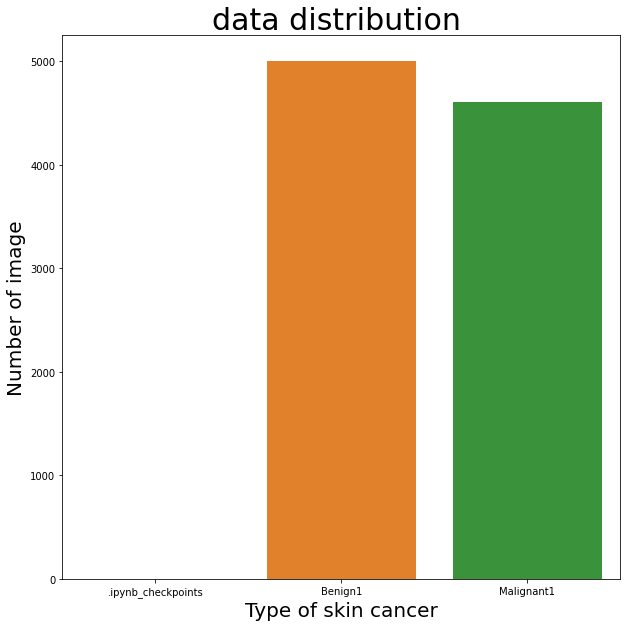

In [ ]:
plt.figure(figsize=(10,10))
plt.title('data distribution ',fontsize=30)
plt.ylabel('Number of image',fontsize=20)
plt.xlabel('Type of skin cancer',fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)

In [ ]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.25
                                                         )
classes = ['Benign1', 'Malignant1']
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.25)
train_data = train_gen.flow_from_directory(train_dir, subset='training', target_size=(224,224),
                                           batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=True,classes=classes)

test_data = valid_gen.flow_from_directory(train_dir, subset='validation', target_size=(224,224),
                                          batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=False,classes=classes)

Found 7205 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.


First Image Shape: (224, 224, 3)
First Label: [0. 1.]


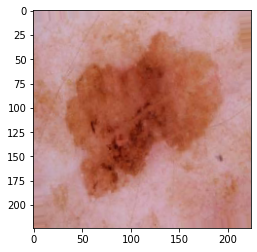

In [ ]:
# Get the first batch of images and labels from the training generator
batch_images, batch_labels = next(train_data)

# Get the first image and its corresponding label
first_image = batch_images[0]
first_label = batch_labels[0]
plt.imshow(first_image)

# Display or process the first image and label as needed
print("First Image Shape:", first_image.shape)
print("First Label:", first_label)


In [ ]:
train_steps = train_data.n//train_data.batch_size
print(train_steps)

112


In [ ]:
test_steps = test_data.n//test_data.batch_size
print(test_steps)

37


In [ ]:
vvg = VGG16(input_shape=(224,224, 3), include_top=False,weights = 'imagenet')

In [ ]:
for layers in (vvg.layers):
    layers.trainable = False

In [ ]:
vvg.layers

In [ ]:
vvg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense,Dropout
model = Sequential()


model.add(vvg)
# Add new layers
model.add(Flatten())
model.add(Dense(4096 , activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096 , activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.summary()
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              1

In [ ]:
lr = 1e-6
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

In [ ]:
mcp = ModelCheckpoint('modelVVG_35.h5', verbose=1)

In [ ]:
es = EarlyStopping(patience=5,verbose=1)

In [ ]:
history = model.fit(train_data,steps_per_epoch=train_steps,epochs=35,validation_data=test_data,validation_steps=test_steps,verbose=1,callbacks=[mcp,es])

Epoch 1/35
112/112 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.5680
Epoch 00001: saving model to modelVVG_35.h5
112/112 [==============================] - 296s 3s/step - loss: 0.7074 - accuracy: 0.5680 - val_loss: 0.5708 - val_accuracy: 0.6934
Epoch 2/35
112/112 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.6443
Epoch 00002: saving model to modelVVG_35.h5
112/112 [==============================] - 349s 3s/step - loss: 0.6300 - accuracy: 0.6443 - val_loss: 0.5139 - val_accuracy: 0.7209
Epoch 3/35
112/112 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7040
Epoch 00003: saving model to modelVVG_35.h5
112/112 [==============================] - 323s 3s/step - loss: 0.5621 - accuracy: 0.7040 - val_loss: 0.4553 - val_accuracy: 0.7842
Epoch 4/35
112/112 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.7278
Epoch 00004: saving model to modelVVG_35.h5
112/112 [==============================] - 3

In [ ]:
model.evaluate(test_data, verbose=1, steps=test_steps)

37/37 [==============================] - 59s 2s/step - loss: 0.2871 - accuracy: 0.8805


[0.28708332777023315, 0.8804898858070374]

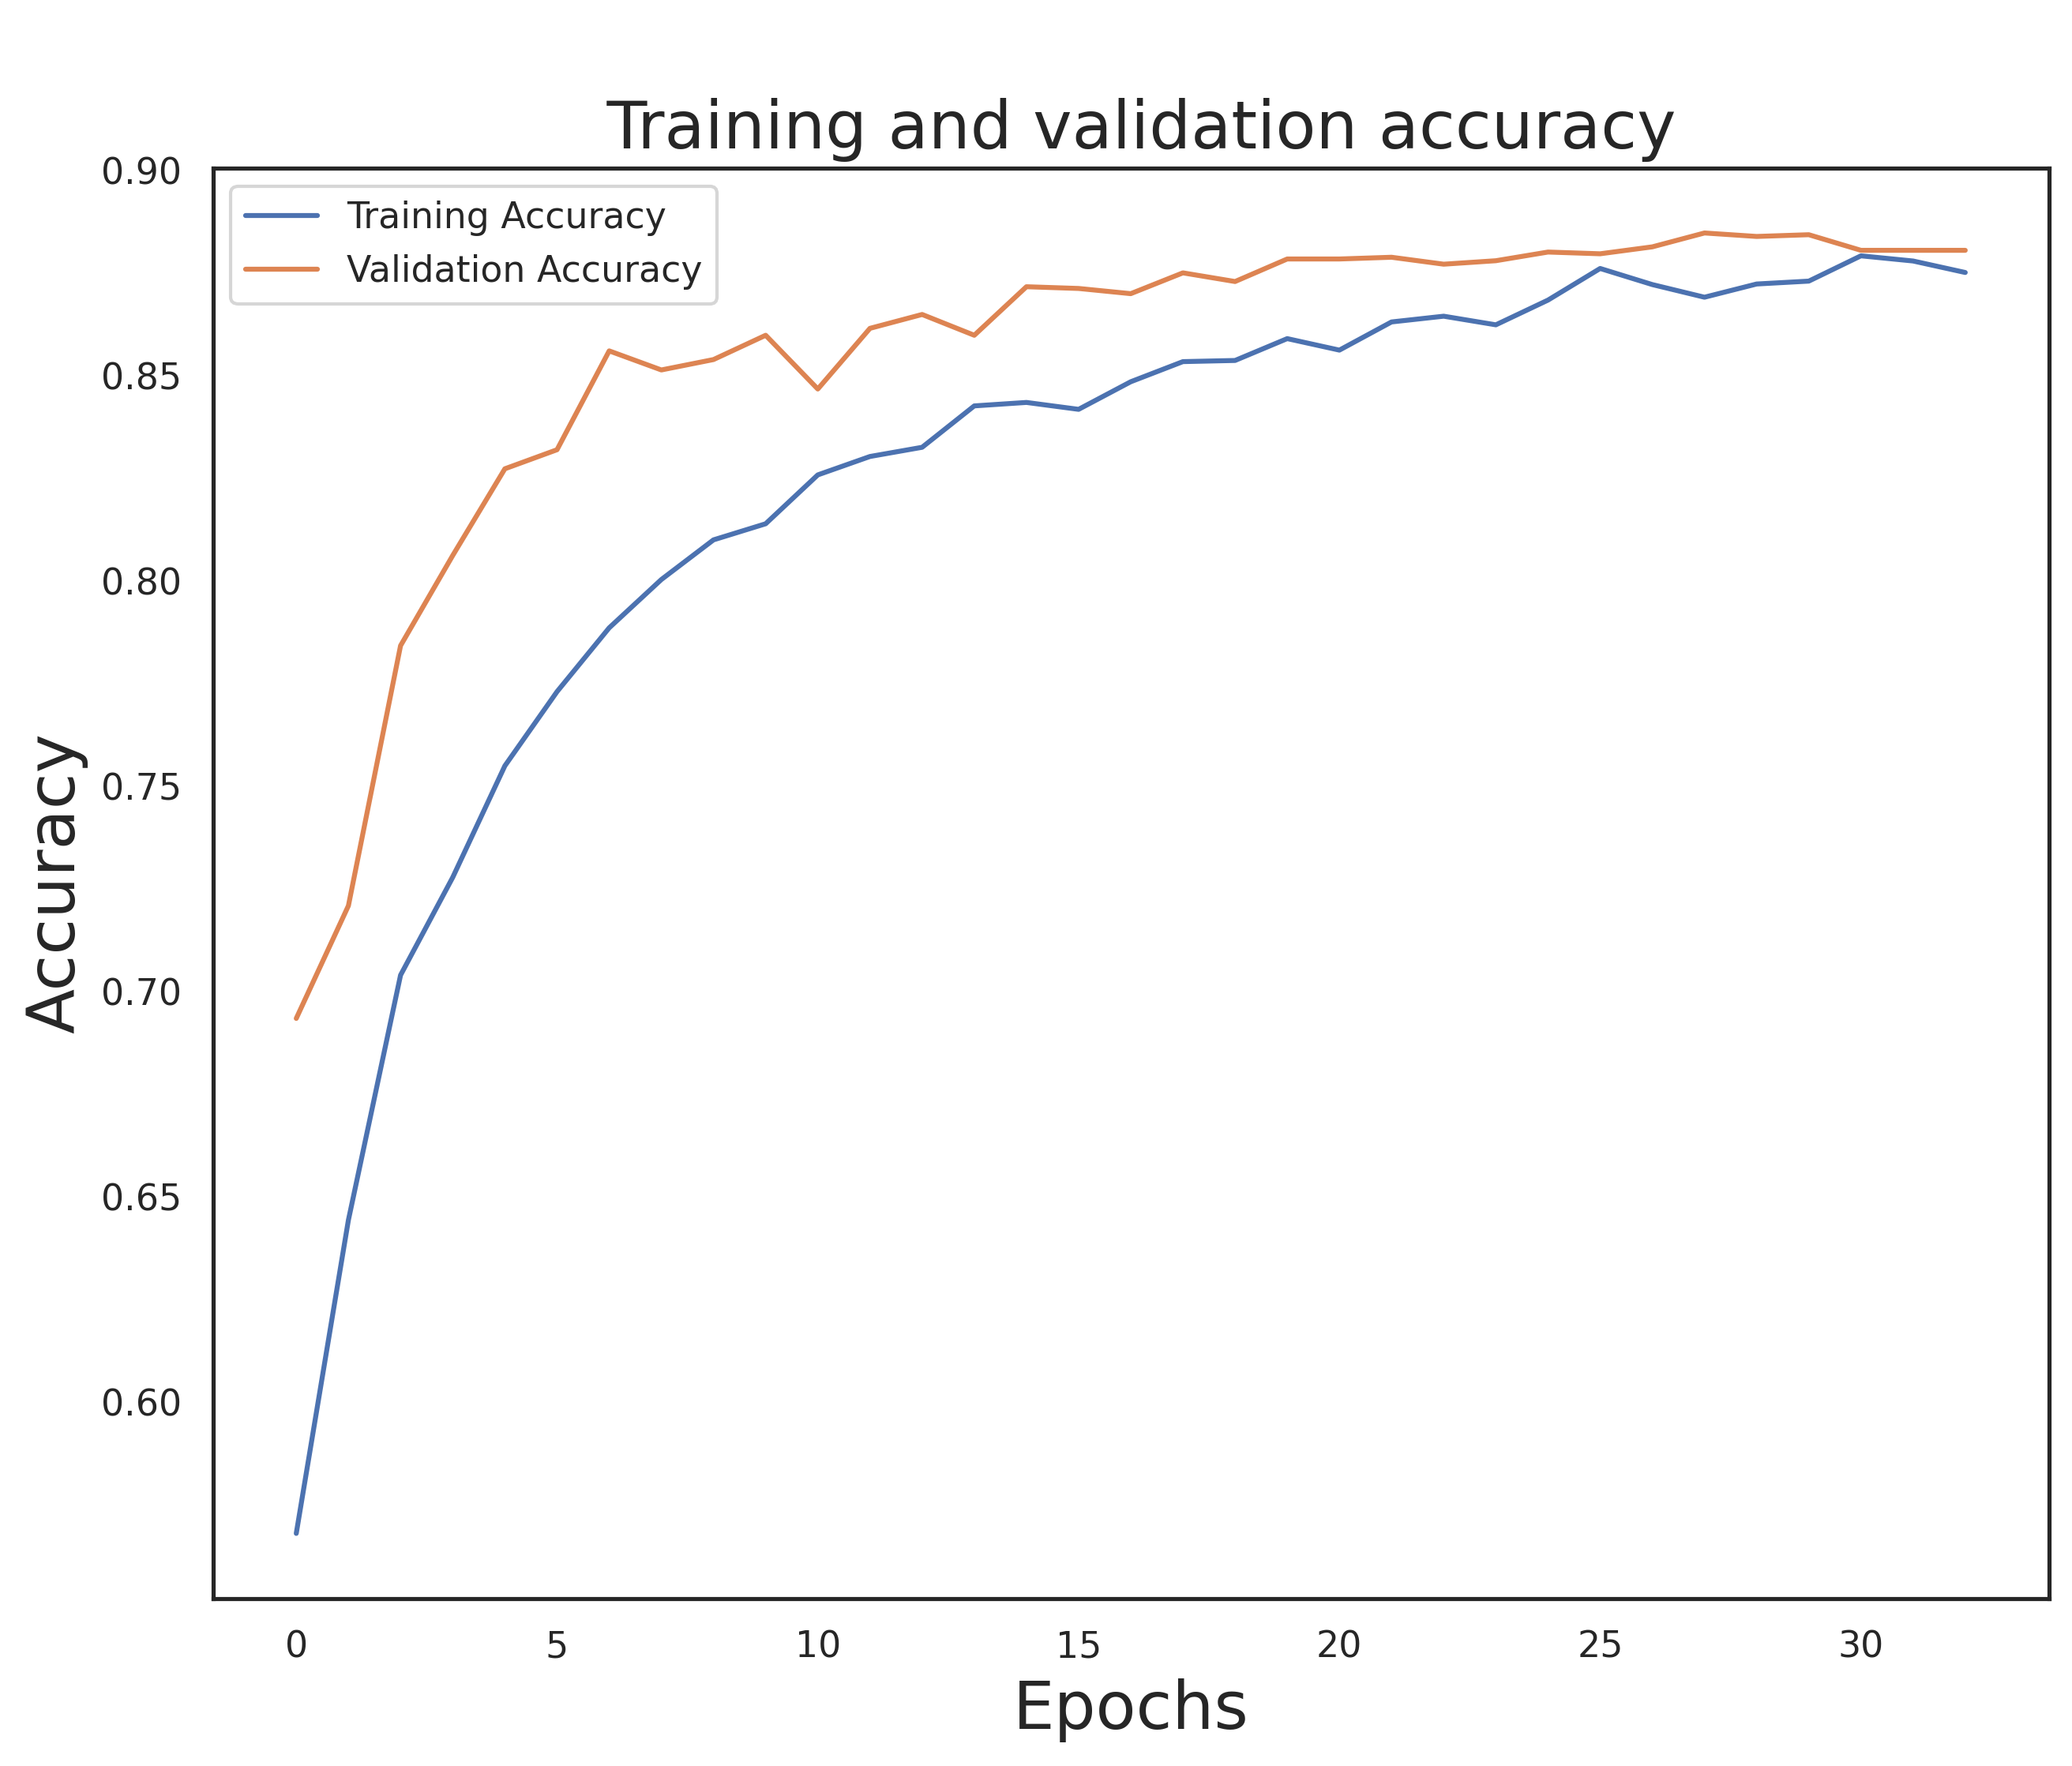

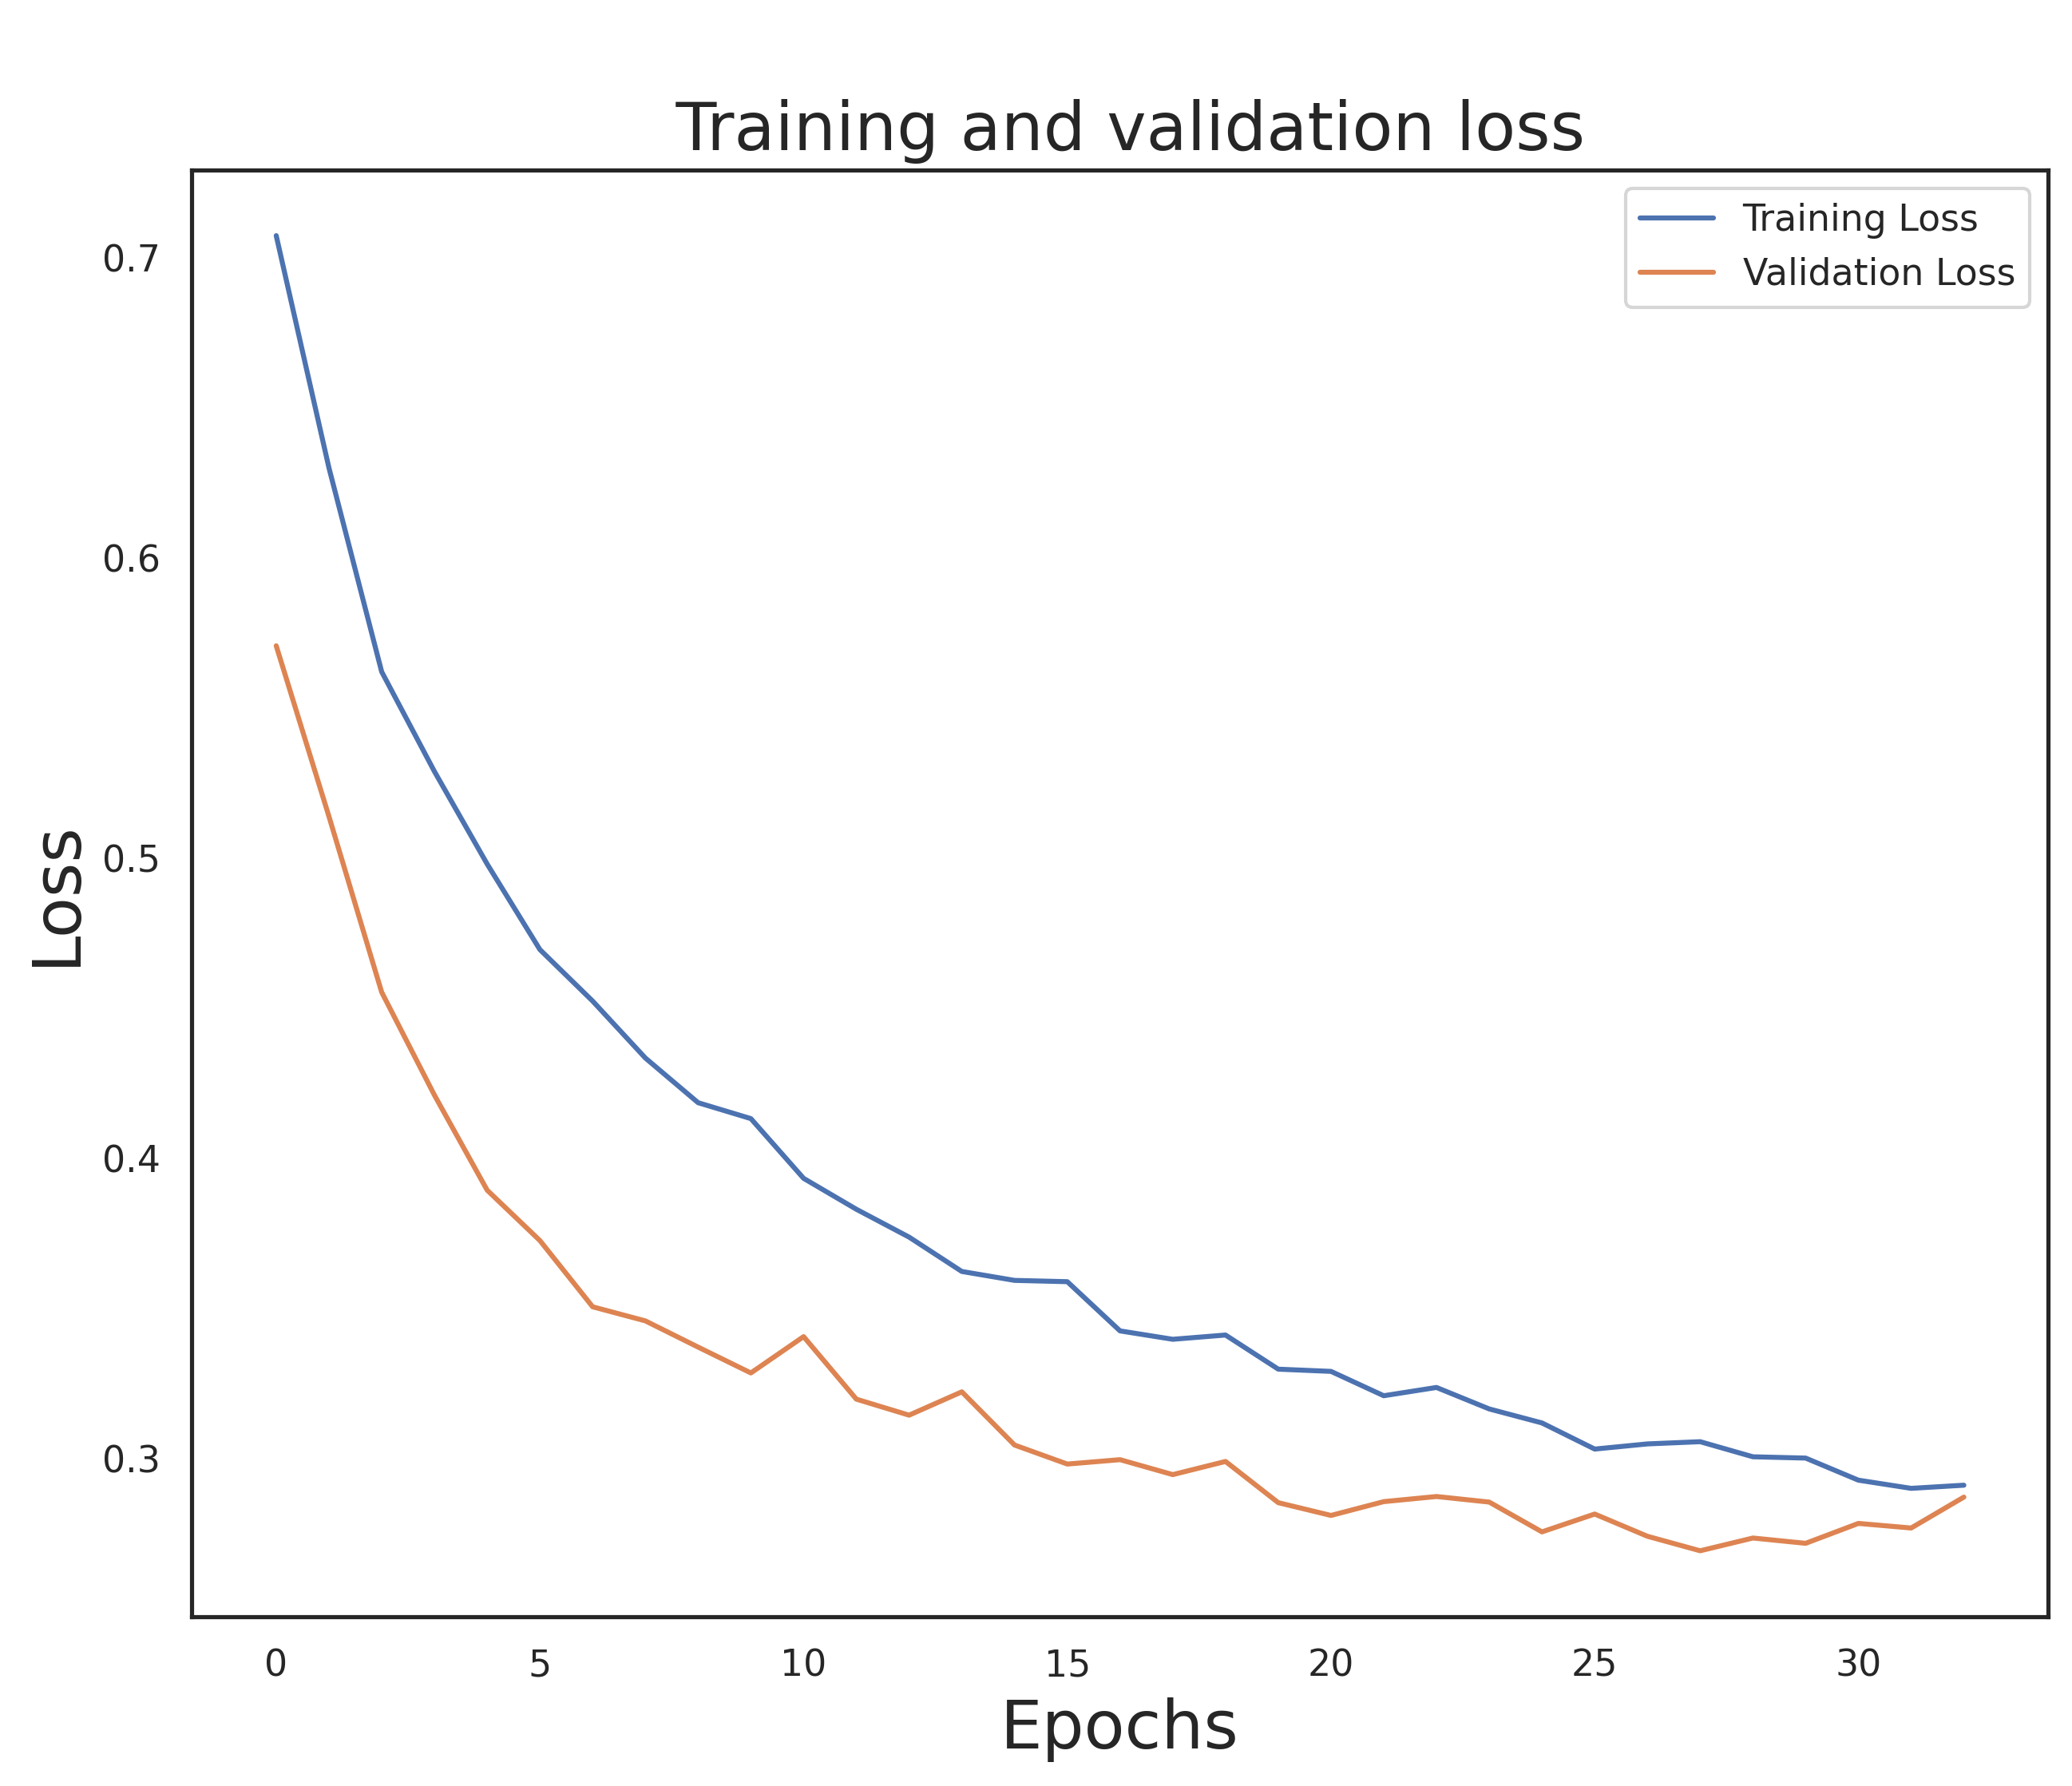

In [ ]:
import matplotlib.pyplot as plt

accuracy      = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(accuracy))

plt.figure(num=None, figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
sns.set(style="white")
plt.plot(epochs, accuracy,label = "Training Accuracy")
plt.plot(epochs, val_accuracy, label = "Validation Accuracy")
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.title('\n Training and validation accuracy',fontsize = 20)
plt.legend()
plt.savefig('Accuracy.png',dpi=400,bbox_inches='tight')
plt.show()

# Plot training and validation loss per epoch
plt.figure(num=None, figsize=(10, 8), dpi=300, facecolor='w', edgecolor='k')
sns.set(style="white")
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = "Validation Loss")
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.title('\n Training and validation loss', fontsize = 20)
plt.legend()
plt.savefig('Loss.png',dpi=400,bbox_inches='tight')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('modelVVG_35.h5')

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1250
           1       0.94      0.80      0.86      1151

    accuracy                           0.88      2401
   macro avg       0.89      0.88      0.88      2401
weighted avg       0.89      0.88      0.88      2401



In [ ]:
train_data.class_indices

{'Benign1': 0, 'Malignant1': 1}

In [ ]:
test_data.class_indices

{'Benign1': 0, 'Malignant1': 1}

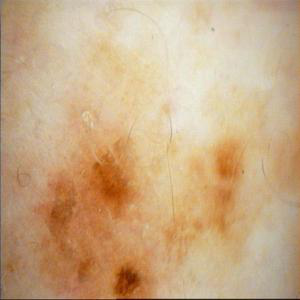

Predicted class: No Melanoma


In [ ]:
from keras.preprocessing import image
import numpy as np
from PIL import Image
from keras.models import load_model
model = load_model('modelVVG_35.h5')

# Step 2: Preprocess the test image
test_image_path = 'Batch 1/Train1/Benign1/melanoma_1021.jpg'  # Change this to the path of your test image
test_image = image.load_img(test_image_path, target_size=(224, 224))  # Assuming VGG11 model requires input size of 224x224
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.  # Normalize the pixel values to the range [0, 1]

predictions = model.predict(test_image)
img = Image.open(test_image_path)
display(img)
# Step 3: Make predictions on the preprocessed test image
predictions = model.predict(test_image)

# Convert predictions to class labels (assuming binary classification)
predicted_class = 'No Melanoma' if predictions[0][0] > predictions[0][1] else 'Melanoma'  # Assuming two classes (0 and 1)  # Adjust this according to your class labels

print("Predicted class:", predicted_class)

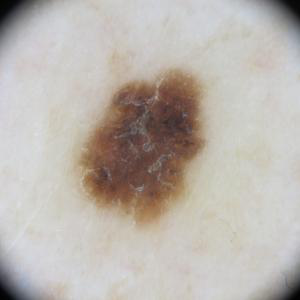

Predicted class: Melanoma


In [ ]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
model = load_model('modelVVG_35.h5')

# Step 2: Preprocess the test image
test_image_path = 'Batch 1/Train1/Malignant1/melanoma_6789.jpg'  # Change this to the path of your test image
test_image = image.load_img(test_image_path, target_size=(224, 224))  # Assuming VGG11 model requires input size of 224x224
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.  # Normalize the pixel values to the range [0, 1]

predictions = model.predict(test_image)
img = Image.open(test_image_path)
display(img)
# Step 3: Make predictions on the preprocessed test image
predictions = model.predict(test_image)

# Convert predictions to class labels (assuming binary classification)
predicted_class = 'No Melanoma' if predictions[0][0] > predictions[0][1] else 'Melanoma'  # Assuming two classes (0 and 1)  # Adjust this according to your class labels

print("Predicted class:", predicted_class)